In [1]:
import numpy as np
import argparse
import dlib
import cv2
import imutils
import matplotlib.pyplot as plt

In [2]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

In [4]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread('./data_true/IMG_3115.jpg')
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detect faces in the grayscale image
rects = detector(gray, 1)

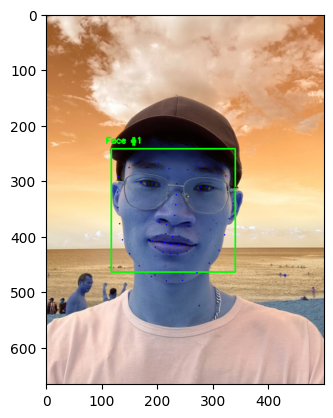

In [5]:
# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region, then
	# convert the facial landmark (x, y)-coordinates to a NumPy
	# array
	shape = predictor(gray, rect)
	shape = shape_to_np(shape)
	# convert dlib's rectangle to a OpenCV-style bounding box
	# [i.e., (x, y, w, h)], then draw the face bounding box
	(x, y, w, h) = rect_to_bb(rect)
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	# show the face number
	cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
	# loop over the (x, y)-coordinates for the facial landmarks
	# and draw them on the image
	for (x, y) in shape:
		cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
# cv2.imshow("Output", image)
plt.imshow(image)
# cv2.waitKey(0)

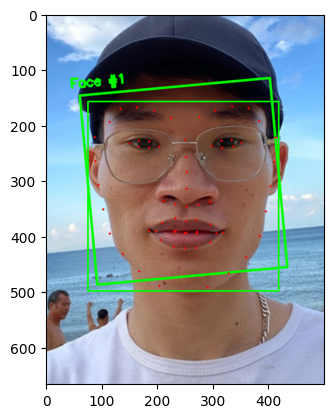

In [6]:
def openface_align(image,shape, rect):
    desiredFaceWidth, desiredFaceHeight= image.shape[1], image.shape[0]
    # compute the center of mass for each eye
    leftEyeCenter = shape[36:42].mean(axis=0).astype("int")
    rightEyeCenter = shape[42:48].mean(axis=0).astype("int")
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) 
    # compute the desired right eye x-coordinate based on the desired x-coordinate of the left eye
    desiredLeftEye=(0.35, 0.35)
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
    dist = np.sqrt((dX ** 2) + (dY ** 2)) # distance between the eyes
    desiredDist = (desiredRightEyeX - desiredLeftEye[0]) * desiredFaceWidth # desired distance between the eyes
    scale = desiredDist / dist
    # compute center (x, y)-coordinates 
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) / 2,
                  (leftEyeCenter[1] + rightEyeCenter[1]) / 2)
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    # update the translation component of the matrix
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
    # apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    # draw bounding box react of face detection after alignment
    (x, y, w, h) = rect_to_bb(rect)
    x = int(x/scale)
    y = int(y/scale)
    w = int(w*scale)
    h = int(h*scale)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return output

output = openface_align(image, shape, rects[0])

plt.imshow(output)